## 코랩 런타임 끊김 방지

In [ ]:
%%html
<audio src="https://henk.tech/colabkobold/silence.m4a" controls>

## 구글 드라이브에 연동

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/AIFFELTHON

DATA = 'the-circor-digiscope-phonocardiogram-dataset-1.0.3/'
HOME_DIR = '/content/drive/MyDrive/aiffel/AIFFELTHON/'
PATH = HOME_DIR + DATA + 'training_data'
SAMPLE_RATE = 4000
HOP_LENGTH = 40

Mounted at /content/drive
/content/drive/MyDrive/aiffel/AIFFELTHON


## 데이터 분석

### 환자 ID를 train, test 데이터로 나눔

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# txt파일 불러오기
file_list = os.listdir(PATH)
txt_list = [os.path.join(PATH, file) for file in file_list if file.endswith(".txt")]

# 환자 아이디를 훈련 데이터셋과 테스트 데이터셋으로 나눔
train_patient_txt, test_patient_txt = train_test_split(txt_list, test_size=0.2, random_state=42)

# 결과 출력
print("Train Patient IDs:", train_patient_txt)
print("Test Patient IDs:", test_patient_txt)

Train Patient IDs: ['/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/82275.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50080.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/84945.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/49930.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50209.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/84933.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/85338.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50742.txt', '/content/drive/MyDrive/aiff

In [3]:

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

file_list = os.listdir(PATH)
patient_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".txt")]

#------------------확인용-------------
wav_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".wav")]
label_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".tsv")]
head_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".hea")]

In [4]:
heas = []
wavs = []
tsvs = []

In [5]:
for path_txt in patient_list:
    #print("{0}.hea".format(path_txt[:-4]))
    with open("{0}.txt".format(path_txt[:-4]), "r") as f:
        P_id, n, sr = f.readline().split()
        for _ in range(int(n)):
            #print(f.readline())
            _, hea, wav, tsv = f.readline().split()
            heas.append(hea)
            wavs.append(wav)
            tsvs.append(tsv)

In [6]:
# 음성 길이 확인
hea_list=[]
for hea in heas:
    path_hea = os.path.join(PATH,hea)
    with open(path_hea, "r") as f:
        id, _, sr, length = f.readline().split()
        hea_list.append(int(length)/float(sr))

평균 :  22.87030121719886
최대값 :  64.512
최소값 :  5.152
----
25
2545


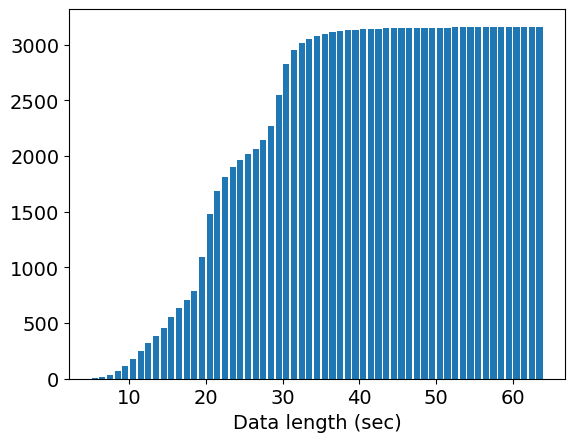

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

hea_list = np.array(hea_list) ## 데이터
bins = np.arange(5,65,1)

print("평균 : ", np.average(hea_list))
print("최대값 : ", np.max(hea_list))
print("최소값 : ", np.min(hea_list))

cut = pd.cut(hea_list, bins=bins) ## 데이터를 일정 구간으로 n등분한다.
#print(cut.describe())

plt.hist(hea_list, bins, rwidth = 0.8, cumulative=True)
plt.xlabel('Data length (sec)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
print("----")
hist, _ =np.histogram(hea_list, bins=bins)
end_index = np.searchsorted(bins, 29, side='right')
print(end_index)

count = np.sum(hist[0:25])
print(count)#5~28초 사이의 데이터 개수

In [8]:
s1_ranges = []
s2_ranges = []
for tsv in tsvs:
    path_tsv = os.path.join(PATH,tsv)
    with open(path_tsv, "r") as f:
        while 1:
            line = f.readline()
            if not line: break
            start, end, s_type = line.split()
            if s_type == "1":
                s1_ranges.append(float(end)-float(start))

            elif  s_type == "3":
                s2_ranges.append(float(end)-float(start))

In [9]:
s1_ranges = np.array(s1_ranges) ## 데이터
s2_ranges = np.array(s2_ranges)

bins = np.arange(5,65,1)

print("s1 길이 최소값 : ", np.min(s1_ranges))
print("s1 길이 최대값 : ", np.max(s1_ranges))
print("s1 길이 평균 : ", np.average(s1_ranges))
print("---------------------")
print("s2 길이 최소값 : ", np.min(s2_ranges))
print("s2 길이 최대값 : ", np.max(s2_ranges))
print("s2 길이 평균 : ", np.average(s2_ranges))

s1 길이 최소값 :  0.008209000000000799
s1 길이 최대값 :  0.7291699999999999
s1 길이 평균 :  0.119164496582365
---------------------
s2 길이 최소값 :  0.0008700000000008146
s2 길이 최대값 :  0.6797499999999985
s2 길이 평균 :  0.10533918449571068


## 데이터 변환
## wav => (전체 파일 개수, 주파수, 시간)
## tsv => (class, x1, x2)

In [10]:
import math

class Biquad:

  # pretend enumeration
  LOWPASS, HIGHPASS, BANDPASS, NOTCH, PEAK, LOWSHELF, HIGHSHELF = range(7)

  def __init__(self,typ, freq, srate, Q, dbGain = 0):
      types = {
	  Biquad.LOWPASS : self.lowpass,
	  Biquad.HIGHPASS : self.highpass,
	  Biquad.BANDPASS : self.bandpass,
	  Biquad.NOTCH : self.notch,
	  Biquad.PEAK : self.peak,
	  Biquad.LOWSHELF : self.lowshelf,
	  Biquad.HIGHSHELF : self.highshelf
      }
      assert typ in types
      freq = float(freq)
      self.srate = float(srate)
      Q = float(Q)
      dbGain = float(dbGain)
      self.a0 = self.a1 = self.a2 = 0
      self.b0 = self.b1 = self.b2 = 0
      self.x1 = self.x2 = 0
      self.y1 = self.y2 = 0
      # only used for peaking and shelving filter types
      A = math.pow(10, dbGain / 40)
      omega = 2 * math.pi * freq / self.srate
      sn = math.sin(omega)
      cs = math.cos(omega)
      alpha = sn / (2*Q)
      beta = math.sqrt(A + A)
      types[typ](A,omega,sn,cs,alpha,beta)
      # prescale constants
      self.b0 /= self.a0
      self.b1 /= self.a0
      self.b2 /= self.a0
      self.a1 /= self.a0
      self.a2 /= self.a0

  def lowpass(self,A,omega,sn,cs,alpha,beta):
    self.b0 = (1 - cs) /2
    self.b1 = 1 - cs
    self.b2 = (1 - cs) /2
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def highpass(self,A,omega,sn,cs,alpha,beta):
    self.b0 = (1 + cs) /2
    self.b1 = -(1 + cs)
    self.b2 = (1 + cs) /2
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def bandpass(self,A,omega,sn,cs,alpha,beta):
    self.b0 = alpha
    self.b1 = 0
    self.b2 = -alpha
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def notch(self,A,omega,sn,cs,alpha,beta):
    self.b0 = 1
    self.b1 = -2 * cs
    self.b2 = 1
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def peak(self,A,omega,sn,cs,alpha,beta):
    self.b0 = 1 + (alpha * A)
    self.b1 = -2 * cs
    self.b2 = 1 - (alpha * A)
    self.a0 = 1 + (alpha /A)
    self.a1 = -2 * cs
    self.a2 = 1 - (alpha /A)

  def lowshelf(self,A,omega,sn,cs,alpha,beta):
    self.b0 = A * ((A + 1) - (A - 1) * cs + beta * sn)
    self.b1 = 2 * A * ((A - 1) - (A + 1) * cs)
    self.b2 = A * ((A + 1) - (A - 1) * cs - beta * sn)
    self.a0 = (A + 1) + (A - 1) * cs + beta * sn
    self.a1 = -2 * ((A - 1) + (A + 1) * cs)
    self.a2 = (A + 1) + (A - 1) * cs - beta * sn

  def highshelf(self,A,omega,sn,cs,alpha,beta):
    self.b0 = A * ((A + 1) + (A - 1) * cs + beta * sn)
    self.b1 = -2 * A * ((A - 1) + (A + 1) * cs)
    self.b2 = A * ((A + 1) + (A - 1) * cs - beta * sn)
    self.a0 = (A + 1) - (A - 1) * cs + beta * sn
    self.a1 = 2 * ((A - 1) - (A + 1) * cs)
    self.a2 = (A + 1) - (A - 1) * cs - beta * sn

  # perform filtering function
  def __call__(self,x):
    y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - self.a1 * self.y1 - self.a2 * self.y2
    self.x2, self.x1 = self.x1, x
    self.y2, self.y1 = self.y1, y
    return y

  # provide a static result for a given frequency f
  def result(self,f):
    phi = (math.sin(math.pi * f * 2/(2.0 * self.srate)))**2
    return ((self.b0+self.b1+self.b2)**2 - \
    4*(self.b0*self.b1 + 4*self.b0*self.b2 + \
    self.b1*self.b2)*phi + 16*self.b0*self.b2*phi*phi) / \
    ((1+self.a1+self.a2)**2 - 4*(self.a1 + \
    4*self.a2 + self.a1*self.a2)*phi + 16*self.a2*phi*phi)

  def log_result(self,f):
    try:
      r = 10 * math.log10(self.result(f))
    except:
      r = -200
    return r

  # return computed constants
  def constants(self):
    return self.b0,self.b1,self.b2,self.a1,self.a2

In [13]:
import os
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from torchvision import transforms
import torchaudio
import torchaudio.transforms as ta_transforms

class CustomDataset(Dataset):
    def __init__(self, path, txt_list,
                 target_size=(40, 2500),
                 th=25,
                 resizing=False,
                 filtering=False,
                 filter_hz=500):
        self.path = path
        self.txt_list = txt_list
        self.target_size = target_size
        self.th = int(th * SAMPLE_RATE / HOP_LENGTH)
        self.resizing = resizing
        self.filtering = filtering
        self.filter_hz = filter_hz

        self.get_file_list()
        self.x, self.scale_list = self.get_mel_spectrogram()
        self.y = self.get_label()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def get_file_list(self):
        self.heas = []
        self.wavs = []
        self.tsvs = []

        for path_txt in self.txt_list:
            with open(path_txt, "r") as f:
                P_id, n, sr = f.readline().split()
                for _ in range(int(n)):
                    _, hea, wav, tsv = f.readline().split()
                    self.heas.append(hea)
                    self.wavs.append(wav)
                    self.tsvs.append(tsv)
        self.heas.sort()
        self.wavs.sort()
        self.tsvs.sort()

    # torchaudio로 필터링 적용
    def apply_filter_torchaudio(self, audio, cutoff_hz):
        biquad = Biquad(typ=Biquad.LOWPASS, freq=cutoff_hz, srate=SAMPLE_RATE, Q=0.707)
        b0, b1, b2, a1, a2 = biquad.constants()
        b0 = torch.tensor(b0)
        b1 = torch.tensor(b1)
        b2 = torch.tensor(b2)
        a0 = 1
        a1 = torch.tensor(a1)
        a2 = torch.tensor(a2)
        filtered_audio = torchaudio.functional.biquad(audio, b0, b1, b2, a0, a1, a2)
        return filtered_audio

    def padding(self, spec, target_length, padding_value=0):
        pad_width = target_length - spec.shape[-1]
        padded_spec = torch.nn.functional.pad(spec, (0, pad_width, 0, 0), "constant", 0)
        return padded_spec
    # def padding(self, arr, target_length, padding_value=0):
    #     current_length = arr.shape[-1]
    #     pad_width = target_length - current_length
    #     if pad_width > 0:
    #         arr = np.pad(
    #             arr,
    #             ((0, 0), (0, pad_width)),
    #             mode='constant',
    #             constant_values=padding_value)
    #     return arr
    # def padding(self, arr, target_length, padding_value=0):
    #     current_length = arr.shape[-1]
    #     pad_width = target_length - current_length
    #     if pad_width > 0:
    #         # 패딩할 차원을 지정하여 패딩합니다.
    #         arr = np.pad(
    #             arr,
    #             ((0, 0), (0, 0), (0, pad_width)),
    #             mode='constant',
    #             constant_values=padding_value)
    #     return arr

    def resize_spectrogram(self, spec, new_shape):
        resized_spec = transforms.functional.resize(img=spec, size=new_shape, antialias=None)
        return resized_spec
    # def resize_spectrogram(self, spec, new_shape):
    #     resized_spec = resize(spec, new_shape, mode='reflect')
    #     return resized_spec

    def get_mel_spectrogram(self):
        audio_list = []
        scale_list = []

        for path_wav in self.wavs:
            path = os.path.join(self.path, path_wav)
            # # Librosa 이용하여 파일 로드
            # x = librosa.load(path, sr=SAMPLE_RATE)[0]
            # ms = librosa.feature.melspectrogram(
            #     y=x,
            #     sr=SAMPLE_RATE,
            #     n_fft=128,
            #     win_length=100,
            #     hop_length=HOP_LENGTH,
            #     n_mels=40)

            # Torchaudio 이용하여 파일 로드
            x = torchaudio.load(path)[0]
            # Filtering
            if self.filtering is True:
                cutoff_frequency = self.filter_hz
                x = self.apply_filter_torchaudio(x, cutoff_frequency)
            ms = ta_transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                           n_fft=128,
                                           win_length=100,
                                           n_mels=40,
                                           hop_length=HOP_LENGTH)(x)
            scale = 1
            # th보다 길이가 길다면 Slicing
            if ms.shape[-1] > self.th:
                ms = ms[:, :, :self.th]
             # th보다 길이가 짧다면
            elif ms.shape[-1] < self.th:
                # Resizing
                if self.resizing is True:
                    scale = self.th / ms.shape[-1]
                    target_shape = (ms.shape[-2], self.th)
                    ms = self.resize_spectrogram(ms, target_shape)
                # Padding
                else:
                    ms = self.padding(ms, self.th)
            # 최종 Resizing
            ms = self.resize_spectrogram(ms, self.target_size)
            audio_list.append(ms)
            # ms_tensor = torch.tensor(ms, dtype=torch.float32)
            # ms_tensor = ms_tensor.unsqueeze(0)
            # audio_list.append(ms_tensor)
            if self.resizing is True:
                scale_list.append(scale)
        return torch.stack(audio_list), scale_list

    def get_label(self):
        labels = []
        for i, path_tsv in enumerate(self.tsvs):
            label = []
            path = os.path.join(self.path, path_tsv)
            tsv_data = pd.read_csv(path, sep='\t', header=None)
            if self.resizing is True:
                scale = self.scale_list[i]
            for _, tsv_row in tsv_data.iterrows():
                if tsv_row[2] in [1, 3]:
                    # 구간 불러와서 sr값 곱하고 hop_legth로 나누기
                    tsv_row[0] *= SAMPLE_RATE / HOP_LENGTH
                    tsv_row[1] *= SAMPLE_RATE / HOP_LENGTH
                    tsv_row[2] = 0 if tsv_row[2] == 1 else 1    # S1=0, S2=1

                    # # 앞뒤로 두 번째 줄에 있는 길이가 0.01초 미만인 S1, S2 제거
                    # if line == 1 or line == len(tsv_data) - 2:
                    #     s_range = tsv_row[1] - tsv_row[0]
                    #     if s_range < 1:
                    #         continue

                    # th보다 길이가 길다면 Slicing
                    if tsv_row[0] > self.th or tsv_row[1] > self.th:
                        break
                    # th보다 길이가 짧다면
                    else:
                        # resize를 하였다면 라벨 값도 스케일링
                        if self.resizing is True:
                            tsv_row[0] *= scale
                            tsv_row[1] *= scale
                        # 최종 resize한 값 으로 보간
                        tsv_row[0] *= self.target_size[1] / self.th
                        tsv_row[1] *= self.target_size[1] / self.th
                        label.append((int(tsv_row[2]), tsv_row[0], tsv_row[1]))
            labels.append(label)
        return labels

### 패딩, 리사이징 결과 히스토그램 시각화

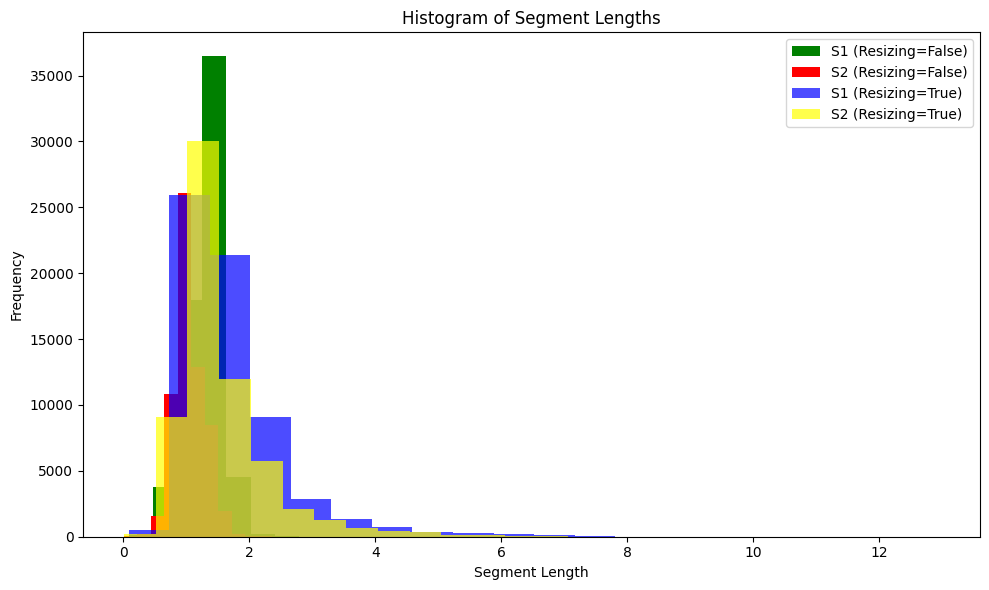

S1 (Resizing=False):
  Min Length: 0.08795357142857796
  Max Length: 7.812535714285701
  Mean Length: 1.2756980236036668 

S1 (Resizing=True):
  Min Length: 0.08795357142857796
  Max Length: 12.949640287769853
  Mean Length: 1.750327470776836 

S2 (Resizing=False):
  Min Length: 0.009321428571439583
  Max Length: 4.283035714285717
  Mean Length: 1.1288262528212827 

S2 (Resizing=True):
  Min Length: 0.009321428571439583
  Max Length: 10.084038461538398
  Mean Length: 1.5513456918433564 



In [14]:
import matplotlib.pyplot as plt

# 데이터셋 생성
dataset_resizing_false = CustomDataset(PATH, txt_list, target_size=(300, 300), th=28, resizing=False, filtering=True)
dataset_resizing_true = CustomDataset(PATH, txt_list, target_size=(300, 300), th=28, resizing=True, filtering=True)

# 데이터와 레이블 추출
data_resizing_false = dataset_resizing_false.x
labels_resizing_false = dataset_resizing_false.y

data_resizing_true = dataset_resizing_true.x
labels_resizing_true = dataset_resizing_true.y

# 클래스별 데이터 길이 저장
class_lengths_resizing_false = {0: [], 1: []}
class_lengths_resizing_true = {0: [], 1: []}

for i in range(len(data_resizing_true)):
    spec_false = data_resizing_false[i]
    label_false = labels_resizing_false[i]
    spec_true = data_resizing_true[i]
    label_true = labels_resizing_true[i]

    for l in label_false:
        class_id, start, end = l
        class_lengths_resizing_false[class_id].append(end - start)

    for l in label_true:
        class_id, start, end = l
        class_lengths_resizing_true[class_id].append(end - start)

# 히스토그램 그리기
plt.figure(figsize=(10, 6))

plt.hist(class_lengths_resizing_false[0], bins=20, alpha=1.0, color='green', label='S1 (Resizing=False)')
plt.hist(class_lengths_resizing_false[1], bins=20, alpha=1.0, color='red', label='S2 (Resizing=False)')
plt.hist(class_lengths_resizing_true[0], bins=20, alpha=0.7, color='blue', label='S1 (Resizing=True)')
plt.hist(class_lengths_resizing_true[1], bins=20, alpha=0.7, color='yellow', label='S2 (Resizing=True)')

plt.xlabel("Segment Length")
plt.ylabel("Frequency")
plt.title("Histogram of Segment Lengths")
plt.legend()

plt.tight_layout()
plt.show()

for class_id in [0, 1]:
    print(f"S{class_id + 1} (Resizing=False):")
    print("  Min Length:", np.min(class_lengths_resizing_false[class_id]))
    print("  Max Length:", np.max(class_lengths_resizing_false[class_id]))
    print("  Mean Length:", np.mean(class_lengths_resizing_false[class_id]), "\n")

    print(f"S{class_id + 1} (Resizing=True):")
    print("  Min Length:", np.min(class_lengths_resizing_true[class_id]))
    print("  Max Length:", np.max(class_lengths_resizing_true[class_id]))
    print("  Mean Length:", np.mean(class_lengths_resizing_true[class_id]), "\n")


### 데이터, 라벨 변환 결과 이미지로 시각화

In [17]:
import matplotlib.pyplot as plt

dataset = dataset_resizing_true
for i, d in enumerate(dataset):
    if i == 20:
        break
    x, y = d
    print(x[0].shape)

    plt.figure(figsize=(10,4))
    # 스펙트로그램 시각화
    librosa.display.specshow(
        librosa.power_to_db(np.array(x[0])), sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')

    # 레이블 시각화
    for label in y:
        class_id, start, end = label
        start /= SAMPLE_RATE / HOP_LENGTH
        end /= SAMPLE_RATE / HOP_LENGTH
        color = 'red' if class_id == 1 else 'blue'
        plt.axvspan(start, end, color=color)

    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram{i + 1} (dB)")

Output hidden; open in https://colab.research.google.com to view.

스펙트로그램 이미지가 가로로 길게 나오는건 mel_spectrogram 인자와 관련이 있는 것 같습니다.  
하지만 (300, 300)의 변환은 올바르게 이루어졌음을 다음과 같은 이유로 간접적으로 알 수 있습니다.
1. 출력 텐서 형태가 [300, 300]입니다.
2. 출력되는 스펙트로그램 이미지가 아래와 같이 (40, 2800)의 형태로 지정했을 때와는 다릅니다.

(300, 300)

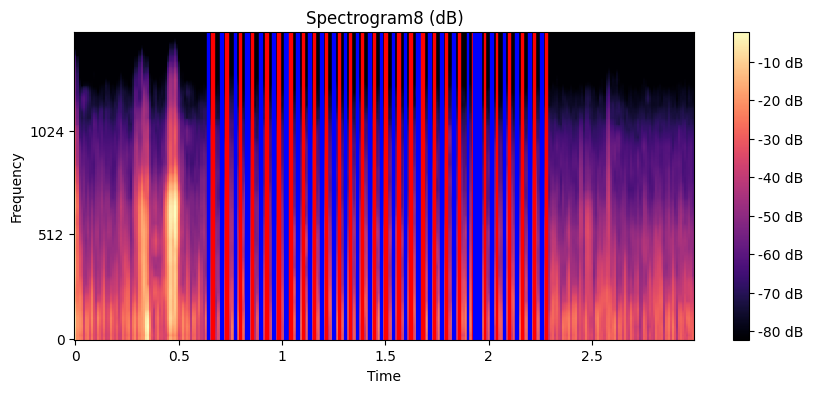

(40, 2800)

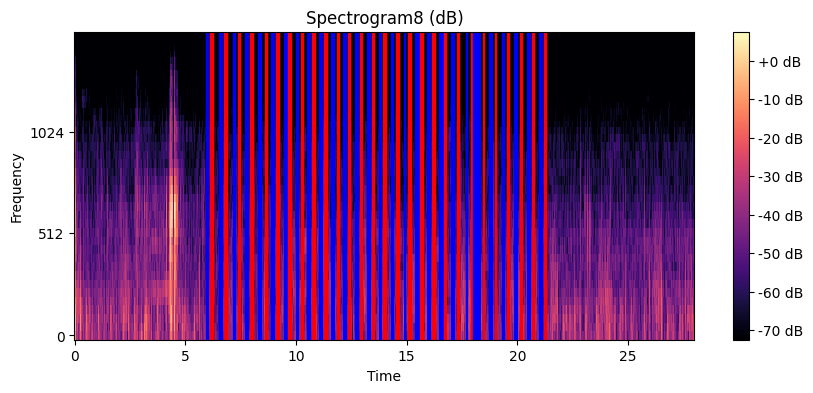

(300, 300)

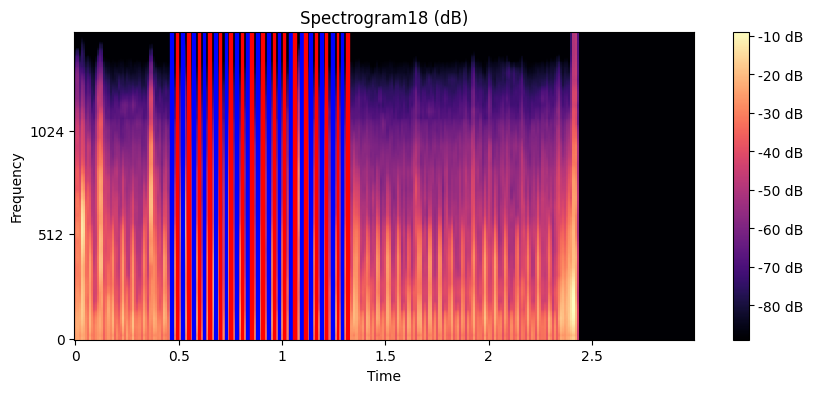

(40, 2800)

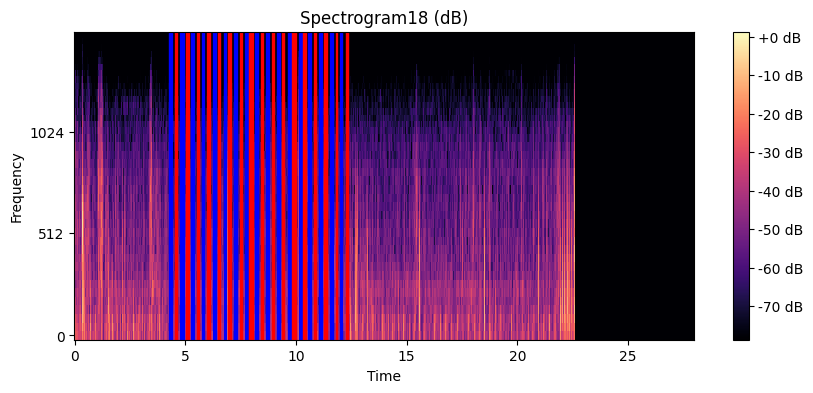